In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret,frame = cap.read()

        # make detections
        image, results = mediapipe_detection(frame, holistic)
        
        draw_styled_landmarks(image, results)
        
        # show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [6]:
draw_styled_landmarks(frame, results)

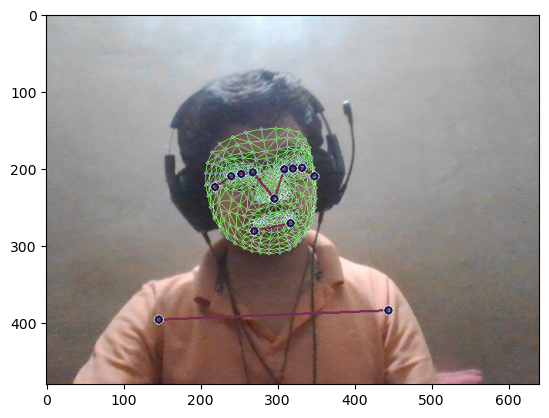

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [9]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [10]:
if results.face_landmarks:
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
else:
    np.zeros(1404)


In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [13]:
result_test = extract_keypoints(results).shape

In [14]:
result_test

(1662,)

In [15]:
np.save('0', result_test)

In [16]:
np.load('0.npy')

array([1662])

In [17]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'yes', 'thanks'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [19]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [20]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
label_map

{'hello': 0, 'yes': 1, 'thanks': 2}

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [25]:
np.array(sequences).shape

(90, 30, 1662)

In [26]:
np.array(labels).shape

(90,)

In [27]:
X = np.array(sequences)

In [28]:
X.shape

(90, 30, 1662)

In [29]:
y = to_categorical(labels).astype(int)

In [30]:
y.shape

(90, 3)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [32]:
X_train.shape

(85, 30, 1662)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [23]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [36]:
res = [.7, 0.2, 0.1]

In [37]:
np.argmax(res)

0

In [38]:
actions[np.argmax(res)]

'hello'

In [24]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [40]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 6s 94ms/step - loss: 4.1626 - categorical_accuracy: 0.3412
Epoch 2/500
3/3 [==============================] - 0s 95ms/step - loss: 15.2797 - categorical_accuracy: 0.3647
Epoch 3/500
3/3 [==============================] - 0s 98ms/step - loss: 7.0844 - categorical_accuracy: 0.3412
Epoch 4/500
3/3 [==============================] - 0s 97ms/step - loss: 14.9950 - categorical_accuracy: 0.2941
Epoch 5/500
3/3 [==============================] - 0s 94ms/step - loss: 39.3736 - categorical_accuracy: 0.2471
Epoch 6/500
3/3 [==============================] - 0s 97ms/step - loss: 18.9776 - categorical_accuracy: 0.3412
Epoch 7/500
3/3 [==============================] - 0s 93ms/step - loss: 12.3120 - categorical_accuracy: 0.3294
Epoch 8/500
3/3 [==============================] - 0s 95ms/step - loss: 11.4328 - categorical_accuracy: 0.4353
Epoch 9/500
3/3 [==============================] - 0s 101ms/step - loss: 5.8021 - categorical_accuracy: 0.4235
Epo

3/3 [==============================] - 0s 85ms/step - loss: 0.5407 - categorical_accuracy: 0.7176
Epoch 75/500
3/3 [==============================] - 0s 94ms/step - loss: 0.5740 - categorical_accuracy: 0.7412
Epoch 76/500
3/3 [==============================] - 0s 95ms/step - loss: 0.5607 - categorical_accuracy: 0.7294
Epoch 77/500
3/3 [==============================] - 0s 86ms/step - loss: 0.5598 - categorical_accuracy: 0.7176
Epoch 78/500
3/3 [==============================] - 0s 92ms/step - loss: 0.5769 - categorical_accuracy: 0.6588
Epoch 79/500
3/3 [==============================] - 0s 87ms/step - loss: 0.5425 - categorical_accuracy: 0.7412
Epoch 80/500
3/3 [==============================] - 0s 91ms/step - loss: 0.5583 - categorical_accuracy: 0.7294
Epoch 81/500
3/3 [==============================] - 0s 93ms/step - loss: 0.5472 - categorical_accuracy: 0.7529
Epoch 82/500
3/3 [==============================] - 0s 90ms/step - loss: 0.5524 - categorical_accuracy: 0.6824
Epoch 83/500
3

3/3 [==============================] - 0s 88ms/step - loss: 0.5129 - categorical_accuracy: 0.7412
Epoch 148/500
3/3 [==============================] - 0s 84ms/step - loss: 0.6981 - categorical_accuracy: 0.7059
Epoch 149/500
3/3 [==============================] - 0s 80ms/step - loss: 0.6892 - categorical_accuracy: 0.6471
Epoch 150/500
3/3 [==============================] - 0s 77ms/step - loss: 0.5873 - categorical_accuracy: 0.6824
Epoch 151/500
3/3 [==============================] - 0s 75ms/step - loss: 0.5181 - categorical_accuracy: 0.6824
Epoch 152/500
3/3 [==============================] - 0s 74ms/step - loss: 0.5441 - categorical_accuracy: 0.7647
Epoch 153/500
3/3 [==============================] - 0s 82ms/step - loss: 0.5112 - categorical_accuracy: 0.7294
Epoch 154/500
3/3 [==============================] - 0s 93ms/step - loss: 0.5092 - categorical_accuracy: 0.7294
Epoch 155/500
3/3 [==============================] - 0s 86ms/step - loss: 0.5212 - categorical_accuracy: 0.7647
Epoch 

3/3 [==============================] - 0s 77ms/step - loss: 0.4887 - categorical_accuracy: 0.7647
Epoch 221/500
3/3 [==============================] - 0s 89ms/step - loss: 0.4015 - categorical_accuracy: 0.7882
Epoch 222/500
3/3 [==============================] - 0s 92ms/step - loss: 0.4520 - categorical_accuracy: 0.8235
Epoch 223/500
3/3 [==============================] - 0s 102ms/step - loss: 0.4422 - categorical_accuracy: 0.7412
Epoch 224/500
3/3 [==============================] - 0s 82ms/step - loss: 0.4251 - categorical_accuracy: 0.8235
Epoch 225/500
3/3 [==============================] - 0s 96ms/step - loss: 0.4084 - categorical_accuracy: 0.7882
Epoch 226/500
3/3 [==============================] - 0s 105ms/step - loss: 0.3465 - categorical_accuracy: 0.8706
Epoch 227/500
3/3 [==============================] - 0s 92ms/step - loss: 0.3280 - categorical_accuracy: 0.8941
Epoch 228/500
3/3 [==============================] - 0s 111ms/step - loss: 0.3471 - categorical_accuracy: 0.8471
Epo

Epoch 293/500
3/3 [==============================] - 0s 109ms/step - loss: 0.1685 - categorical_accuracy: 0.9647
Epoch 294/500
3/3 [==============================] - 0s 106ms/step - loss: 0.1502 - categorical_accuracy: 0.9529
Epoch 295/500
3/3 [==============================] - 0s 112ms/step - loss: 0.1652 - categorical_accuracy: 0.9294
Epoch 296/500
3/3 [==============================] - 0s 118ms/step - loss: 0.1438 - categorical_accuracy: 0.9765
Epoch 297/500
3/3 [==============================] - 0s 124ms/step - loss: 0.1704 - categorical_accuracy: 0.9529
Epoch 298/500
3/3 [==============================] - 0s 118ms/step - loss: 0.1366 - categorical_accuracy: 0.9529
Epoch 299/500
3/3 [==============================] - 0s 119ms/step - loss: 0.1625 - categorical_accuracy: 0.9176
Epoch 300/500
3/3 [==============================] - 0s 116ms/step - loss: 0.3089 - categorical_accuracy: 0.8941
Epoch 301/500
3/3 [==============================] - 0s 104ms/step - loss: 0.2774 - categorical_

3/3 [==============================] - 1s 178ms/step - loss: 0.2874 - categorical_accuracy: 0.8471
Epoch 366/500
3/3 [==============================] - 1s 186ms/step - loss: 0.2565 - categorical_accuracy: 0.8941
Epoch 367/500
3/3 [==============================] - 1s 171ms/step - loss: 0.2750 - categorical_accuracy: 0.8471
Epoch 368/500
3/3 [==============================] - 1s 168ms/step - loss: 0.2491 - categorical_accuracy: 0.9412
Epoch 369/500
3/3 [==============================] - 1s 160ms/step - loss: 0.3030 - categorical_accuracy: 0.8235
Epoch 370/500
3/3 [==============================] - 0s 148ms/step - loss: 0.3005 - categorical_accuracy: 0.8471
Epoch 371/500
3/3 [==============================] - 0s 173ms/step - loss: 0.2317 - categorical_accuracy: 0.9176
Epoch 372/500
3/3 [==============================] - 1s 192ms/step - loss: 0.2369 - categorical_accuracy: 0.9176
Epoch 373/500
3/3 [==============================] - 1s 180ms/step - loss: 0.2372 - categorical_accuracy: 0.92

3/3 [==============================] - 0s 117ms/step - loss: 0.2392 - categorical_accuracy: 0.9176
Epoch 438/500
3/3 [==============================] - 0s 130ms/step - loss: 0.1621 - categorical_accuracy: 0.9529
Epoch 439/500
3/3 [==============================] - 0s 161ms/step - loss: 0.2397 - categorical_accuracy: 0.8941
Epoch 440/500
3/3 [==============================] - 1s 172ms/step - loss: 0.1736 - categorical_accuracy: 0.9647
Epoch 441/500
3/3 [==============================] - 0s 122ms/step - loss: 0.1437 - categorical_accuracy: 0.9765
Epoch 442/500
3/3 [==============================] - 0s 126ms/step - loss: 0.1544 - categorical_accuracy: 0.9412
Epoch 443/500
3/3 [==============================] - 0s 124ms/step - loss: 0.2886 - categorical_accuracy: 0.8824
Epoch 444/500
3/3 [==============================] - 0s 122ms/step - loss: 0.6355 - categorical_accuracy: 0.7176
Epoch 445/500
3/3 [==============================] - 0s 123ms/step - loss: 0.3958 - categorical_accuracy: 0.84

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trai

In [25]:
res = model.predict(X_test)

NameError: name 'X_test' is not defined

In [43]:
actions[np.argmax(res[4])]

'yes'

In [44]:
actions[np.argmax(y_test[4])]

'yes'

In [28]:
model.save('action.h5')

In [27]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [29]:
yhat = model.predict(X_train)

NameError: name 'X_train' is not defined

In [48]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [49]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[53,  2],
        [ 1, 29]],

       [[57,  1],
        [ 2, 25]],

       [[57,  0],
        [ 0, 28]]], dtype=int64)

In [50]:
accuracy_score(ytrue, yhat)

0.9647058823529412

In [30]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [31]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

IndexError: list index out of range

<Figure size 1800x1800 with 0 Axes>

In [66]:
sequence.reverse()

In [67]:
len(sequence)

30

In [68]:
sequence.append('def')

In [69]:
sequence.reverse()

In [70]:
sequence[-30:]

[array([ 0.60593355,  0.76255739, -2.61261463, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60840976,  0.7660116 , -2.61260343, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60856938,  0.76639831, -2.83457041, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.6085704 ,  0.76629168, -2.62061167, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60898477,  0.76528871, -2.78265047, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60668898,  0.76337373, -2.66454554, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60151267,  0.76180154, -2.53414059, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.59070712,  0.76199168, -2.61843157, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.56614506,  0.72032917, -2.47954655, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55388248,  0.7050544 , -2.3266542 , ...,  0.        ,
         0.        ,  0.  

In [32]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [63]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
(num_sequences,30,1662)

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))